# Exploratory Data Analysis Report

## 1. Overview

**Project Title**  
Phase 1 – Exploratory Data Analysis (EDA): Solana Token Panel

**Aim of EDA**  
To assess the structure, completeness, and distributional characteristics of the 12 h‐aggregated Solana token panel—informing feature engineering and guiding interval‐forecast model design 

**Data Sources**  
- **Master panel** (`solana_master_raw.parquet`): merged 12 h OHLCV, on-chain metrics, sentiment proxies and market‐context tables over 2024-12-05 to 2025-06-03 (8326 rows × 29 columns; 23 tokens) 
- **Token metadata:** `tokens.csv` → mapping symbols ↔ mints   
- **OHLCV:** per-token CSVs in `tokens/` directory, deduplicated and aligned to a global 12 h index  
- **On-chain metrics:**  
  - `holders.csv` (holder_count)  
  - `new_token_accounts.csv`  
  - `token_transfers.csv` (transfer_count)   
- **Global market context:**  
  - `btc_eth_price.csv`  
  - `sol_price.csv`  
  - `network_transaction_counts.csv`  
  - `tvl.csv`  
  - `SPL Program Instructions.csv` 


---

## 2. Data Description

**Master panel** (`solana_master_raw.parquet`)  
- **Size & scope:** 8 326 rows × 29 columns; 23 unique tokens; 12 h bins from 2024-12-05 00:00 to 2025-06-03 12:00  
- **Frequency:** 12-hour  

**Key fields by category**  
- **OHLCV**: `open_usd`, `high_usd`, `low_usd`, `close_usd`, `volume_usd`  
- **On-chain metrics**: `holder_count`, `new_token_accounts`, `transfer_count`  
- **Market context**: `tvl_tvl_usd`, `tvl_tvl_change_12h`, `btc_eth_price_eth_low`, `sol_price_close`, `sol_price_low`, `sol_price_volume`  
- **Metadata**: `token_name`  

---

### Column summary (data types & missingness)

| Column                    | Dtype     | % Missing |
|---------------------------|-----------|-----------|
| `holder_count`            | float64   | 39.36     |
| `open_usd`                | float64   | 18.30     |
| `high_usd`                | float64   | 18.30     |
| `low_usd`                 | float64   | 18.30     |
| `close_usd`               | float64   | 18.30     |
| `token_name`              | object    | 12.64     |
| `volume_usd`              | float64   | 12.64     |
| `new_token_accounts`      | float64   | 9.92      |
| `transfer_count`          | float64   | 9.90      |
| `tvl_tvl_change_12h`      | float64   | 0.55      |
| `tvl_tvl_usd`             | float64   | 0.55      |
| `btc_eth_price_eth_low`   | float64   | 0.28      |
| `sol_price_volume`        | float64   | 0.28      |
| `sol_price_close`         | float64   | 0.28      |
| `sol_price_low`           | float64   | 0.28      |

(Only a subset shown; full 29-column summary available in notebook.) 


---

## 3. Preprocessing & QA Checklist

This section summarizes all data-cleaning, imputation, token-filtering, and validation steps applied to the raw 12 h Solana panel, using only the attached data-processing notebooks.

**3.1 Master 12 h Index & Table Alignment**  
- Defined the overall start/end timestamps across all source tables and generated a uniform 12 h time index.  
- Reindexed and forward-filled global tables (`btc_eth_price.csv`, `sol_price.csv`, `network_transaction_counts.csv`, `tvl.csv`, `SPL Program Instructions.csv`) onto the master index to eliminate gaps.  
- Reindexed per-token tables (`holders.csv`, `new_token_accounts.csv`, `token_transfers.csv`, and each token’s OHLCV CSV) to the same index, introducing NaNs where data was missing.  
- Merged per-token tables on `(token_mint, timestamp)` and then merged global tables on `timestamp` to produce the raw master panel (`solana_master_raw.parquet`)

**3.2 OHLCV Cleaning**  
- Dropped any token lacking a single fully-observed OHLCV bar (e.g. `COLLAT`, `titcoin`).  
- Flagged rows where *any* of `open_usd`, `high_usd`, `low_usd`, `close_usd`, or `volume_usd` was missing.  
- For each token, identified its “launch” as the first timestamp with all five OHLCV fields present and discarded all earlier rows.  
- Removed any remaining rows with missing OHLCV values, ensuring a fully observed OHLCV history

**3.3 OHLCV Imputation**  
- Forward-filled up to two consecutive missing 12 h intervals per token to patch short gaps.  
- Applied linear interpolation on any remaining OHLCV gaps.  
- Validated that zero missing values remained in the core OHLCV fields after imputation

**3.4 Token-Level Missingness Strategy**  
- From the OHLCV missingness analysis:  
  - Tokens with > 30 % of OHLCV bars missing were dropped entirely (e.g. `COLLAT`, `titcoin`).  
  - Tokens whose data began late but was thereafter complete had only their early empty rows clipped.  
  - Internal gaps of ≤ 2 bins were forward-filled; longer gaps were dropped.  
- Annotated every imputed row with a `was_imputed` flag for downstream diagnostics

**3.5 On-Chain Metrics Imputation**  
- Holder counts, new token accounts, and transfer counts exhibited ~ 10 % missingness outside the on-chain start window; small gaps were forward-filled or median-filled, larger gaps flagged for potential masking.  
- Restricted use of `holder_count` to timestamps ≥ 2025-02-07, when on-chain data collection began

**3.6 QA & Validation Checks**  
- Raw panel (6 464 rows) reduced to 6 440 after OHLCV cleaning; no residual OHLCV missing values post-imputation.  
- Ensured no duplicate `(token, timestamp)` pairs and strictly increasing timestamps per token.  
- Confirmed final dataset integrity and saved as `solana_cleaned_imputed_final.parquet`.

**3.7 Reproducibility & Logging**  
- Encapsulated all cleaning logic in `clean_ohlcv_panel()` and imputation logic in `impute_ohlcv()` (or optional Kalman variant) within the data-processing notebooks.  
- Retained row-level flags (`post_launch`, `was_imputed`, `was_imputed_onchain`) throughout to enable full auditability and conditional downstream modeling.  


---

## 4. Notebook Summaries

### Data Missingness

**Purpose**  
To characterize gaps in the raw 12 h OHLCV and on‐chain tables, identify token‐ and feature‐level missingness patterns, and determine which tokens or rows to drop, clip, or impute before any feature engineering .

---

**Methods**  
- Flagged any 12 h row as missing if _any_ of `open_usd`, `high_usd`, `low_usd`, `close_usd`, or `volume_usd` was null, and computed per‐token and per‐timestamp missingness rates.  
- Pivoted to a token×timestamp binary matrix and rendered an OHLCV Missingness Heatmap to visually classify gaps into three categories:  
  1. **Pre-launch gaps** (complete absence at the start)  
  2. **Random internal gaps** (sporadic missing bars mid-timeline)  
  3. **Incomplete starts** (late but then stable data) :contentReference[oaicite:0]{index=0}  
- Determined that on-chain metrics (`holder_count`, `new_token_accounts`, `transfer_count`) were structurally missing before 2025-02-07 12:00 UTC by inspecting the first non-null timestamp per token. :contentReference[oaicite:1]{index=1}  
- After aligning to the on-chain start date, performed a post-2025-02-07 missingness audit showing ~12–13 % OHLCV gaps, ~5–6 % on-chain gaps, and < 1 % in global market fields. :contentReference[oaicite:2]{index=2}

---

**Key Observations**  
- **Pre-launch gaps:** Tokens like **COLLAT** and **titcoin** have no OHLCV bars until well after the global index → cannot model their early history.  
- **Incomplete starts:** Tokens such as **MEW**, **RETARDIO**, **ZEREBRO**, **Ray** begin late but then present complete OHLCV streams.  
- **Random internal gaps:** **WIF**, **FWOG**, **GIGA**, **POPCAT** exhibit scattered missing bars, likely due to indexing failures or illiquidity.  
- **On-chain structural gap:** No holder or transfer data exists before 2025-02-07 12:00 UTC for any token. **LAUNCHCOIN** remains 100 % missing even after that date; **TITCOIN** only appears from 2025-03-06 → must drop when using on-chain features.  
- **Aggregate missingness post-start:** Core OHLCV fields ~ 12–13 %; log-returns ~ 14 %; on-chain metrics ~ 5–6 %; global market context < 1 %.  

---

**Implications**  
1. **Token filtering:**  
   - Drop tokens with > 30 % OHLCV missingness (e.g. COLLAT, titcoin) for all models.  
   - When using on-chain features, also exclude LAUNCHCOIN and TITCOIN.  
2. **Time clipping:**  
   - For “late-starter” tokens, remove all rows before the first complete OHLCV bar.  
   - Use 2025-02-07 12:00 UTC as the earliest timestamp for on-chain data.  
3. **Imputation strategy:**  
   - Forward-fill or median-fill on-chain gaps ≤ 5 % of each token’s record; flag larger blocks.  
   - For OHLCV, forward-fill up to 2 bins then drop any remaining missing rows.  
4. **Flagging:**  
   - Annotate each row with `post_ohlcv_launch` and `was_imputed` for downstream filtering and diagnostics.

---

**Plots**  
- **OHLCV Missingness Heatmap** (green = present, red = missing)  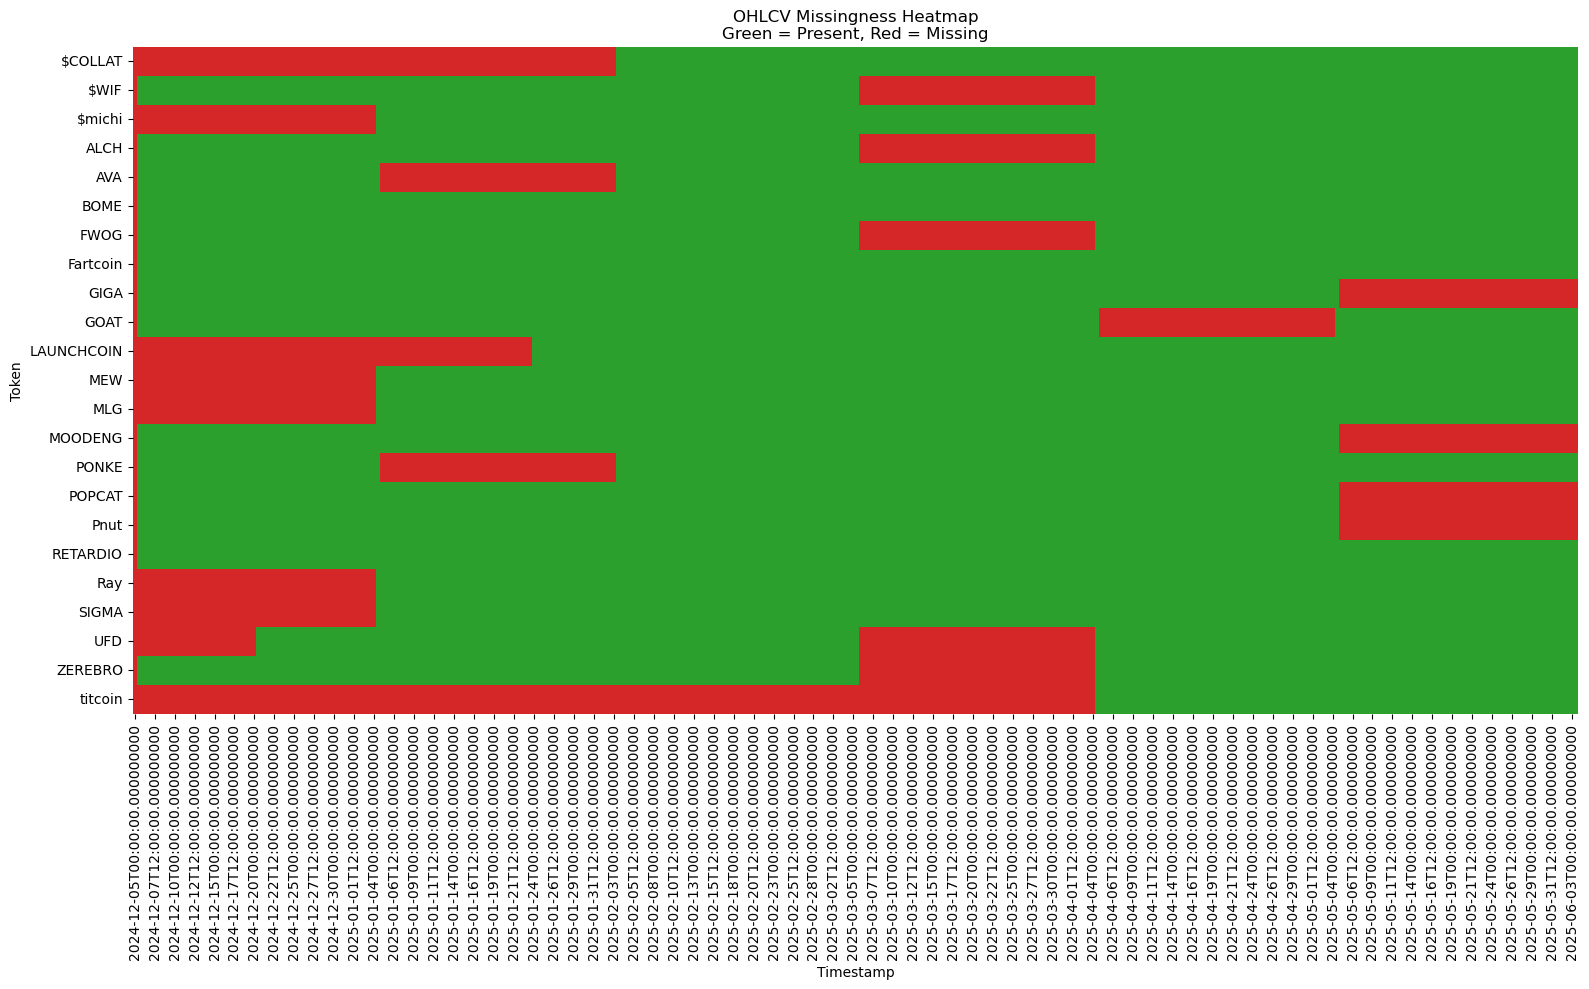
- **Time-Series Missingness of OHLCV Features** (% tokens missing over time)  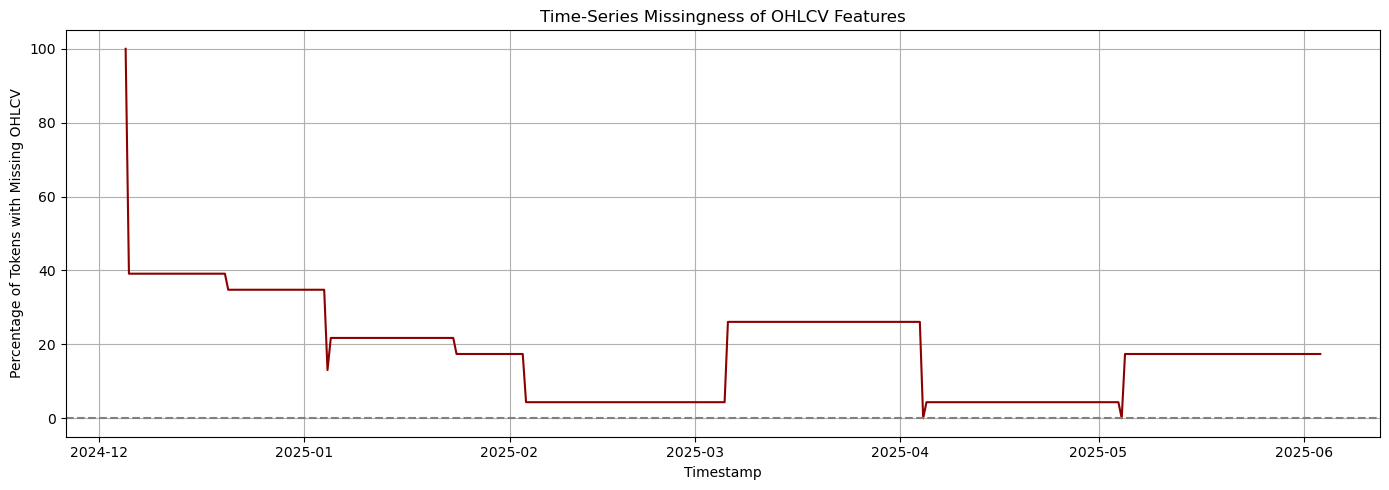
- **Missingness Audit Post-2025-02-07** bar chart of feature-class missingness  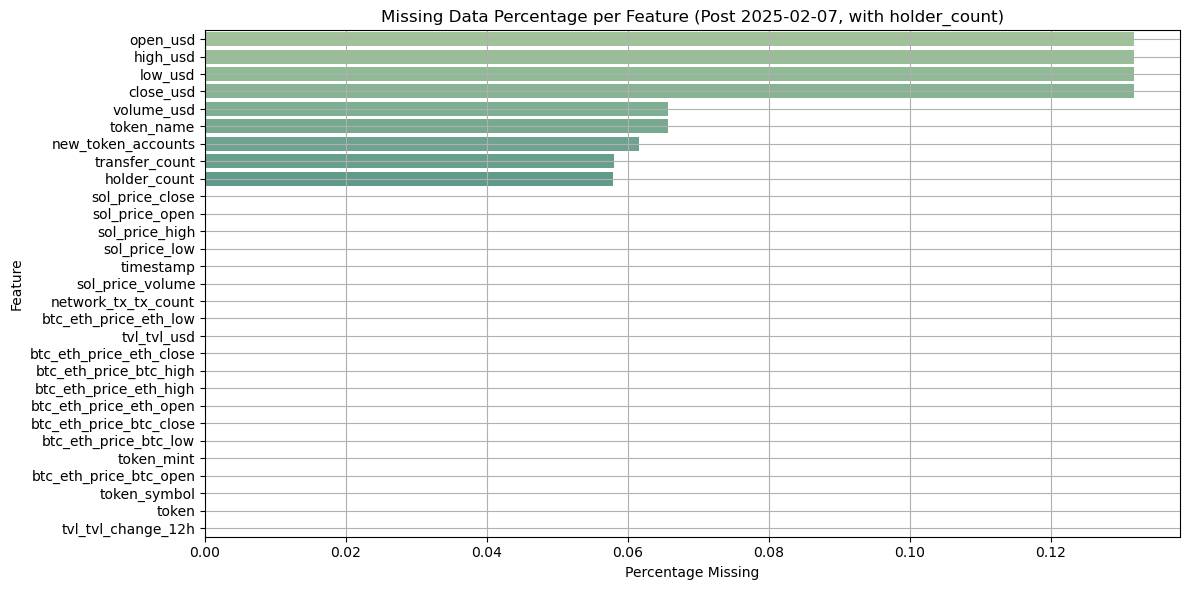

---

**Next Steps**  
- Implement the `clean_ohlcv_panel()` routine to automate token drops, launch clipping, and OHLCV gap removal.  
- Automate a missingness summary report (tables and heatmaps) whenever new data is ingested.  
- Retain and propagate row‐level flags in the feature pipeline to enable conditional modeling and audit trails.  

---

### Return & Volatility Diagnostics

**Purpose**  
Analyze the statistical properties of 12 h and 72 h log‐returns—focusing on distribution shape, tail behavior, autocorrelation and the return–volatility relationship—to inform choice of interval‐forecasting methods. 

---

#### Methods  
- **Data load & scope**: 6 464 rows × 32 columns for 21 tokens, spanning 2024-12-05 12:00 → 2025-06-03 12:00.  
- **Return computation**:  
  - 12 h log‐returns:  
    \`logret_12h = log(close / close.shift(1))\` by token  
  - 72 h log‐returns:  
    \`logret_72h = log(close.shift(-6) / close)\` by token  
- **Distributional diagnostics**:  
  - Histograms + KDE for \`logret_12h\` and \`logret_72h\`  
  - Skewness & kurtosis (overall and per token)  
- **Autocorrelation analysis**:  
  - ACF/PACF of \`logret_12h\`  
  - ACF of \`|logret_12h|\` to detect volatility clustering  
- **Return–volatility relationship**:  
  - Compute 3-bar (36 h) realized volatility:  
    \`realized_vol_12h = rolling_std(logret_12h, window=3)\`  
  - Shift volatility forward one bin (\`lead_vol\`) to align with returns  
  - Scatterplot of \`logret_12h\` vs \`lead_vol\`  
- **Mean-reversion check**:  
  - Naïve lag-1 forecast error series (`error = logret_12h – logret_12h.shift(1)`)  
  - ACF of forecast errors to detect serial dependence 

---

#### Key Observations  
- **Heavy tails & skew**: 12 h returns show right skew (≈ 0.67) and extreme kurtosis (≈ 27.7), confirming non‐Gaussian tails. {index=4}  
- **Volatility clustering**: ACF of \|logret_12h\| remains significantly positive up to lag 20, indicating persistent periods of high/low volatility.  
- **Leverage effect**: Both large positive and negative 12 h returns predict higher next‐period volatility, with downside moves exhibiting a stronger effect.  
- **Mean‐reversion**: Forecast errors from a naïve lag-1 model have strong negative autocorrelation at lag 1, consistent with short‐term reversal dynamics.  
- **Non‐stationary skew regimes**: Return distributions shift shape under different SOL‐price regimes (bull vs bear), suggesting systemic changes in tail asymmetry.

---

#### Implications for Modeling  
1. **Interval method choice**: Fat tails and shifting skewness favor non‐parametric quantile models (e.g. QRF) over Gaussian‐based intervals.  
2. **Feature engineering**: Include rolling volatility, tail‐event indicators (±10 % moves), rolling skewness and directional flags to capture conditional heteroskedasticity and leverage.  
3. **Validation design**: Use rolling‐window cross‐validation to ensure model performance across high‐ and low‐volatility regimes.  
4. **Bias correction**: Address mean‐reversion and serial dependence in forecast errors—potentially via residual‐based calibration or conformal methods.

---

#### Plots 
- Histogram + KDE of 12 h log‐returns  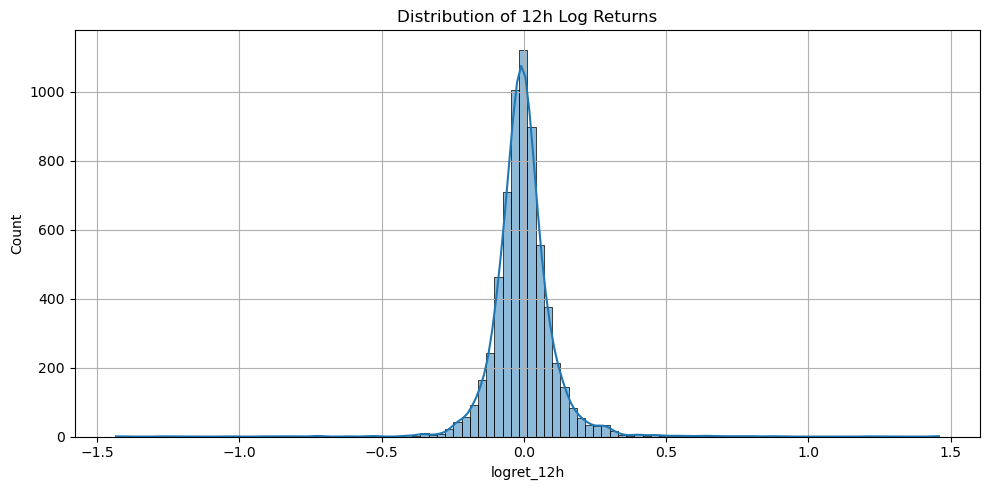
- Scatterplot: 12 h log‐return vs next‐period (36 h) realised volatility  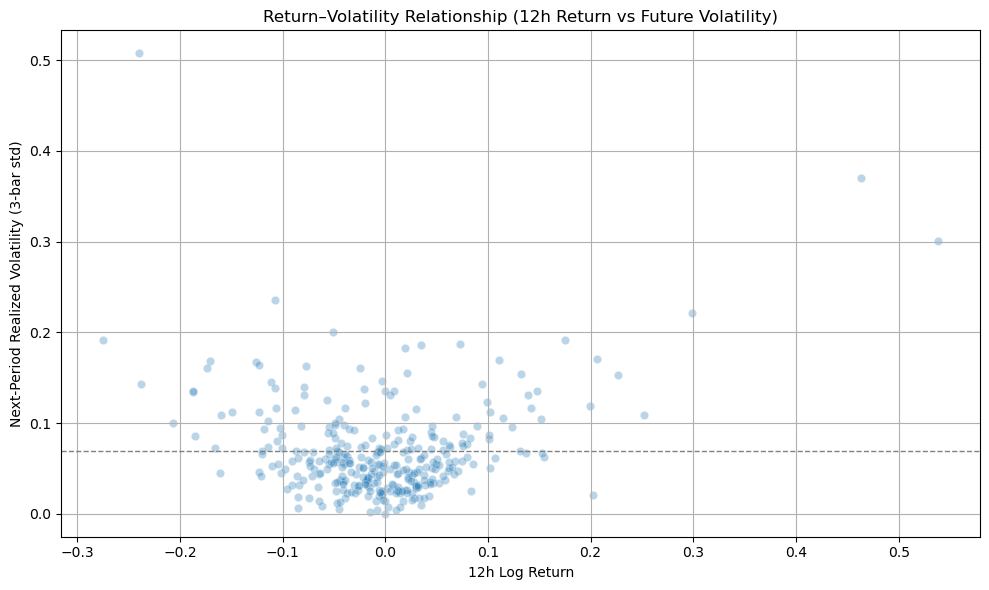
- Rolling Tail Asymmetry 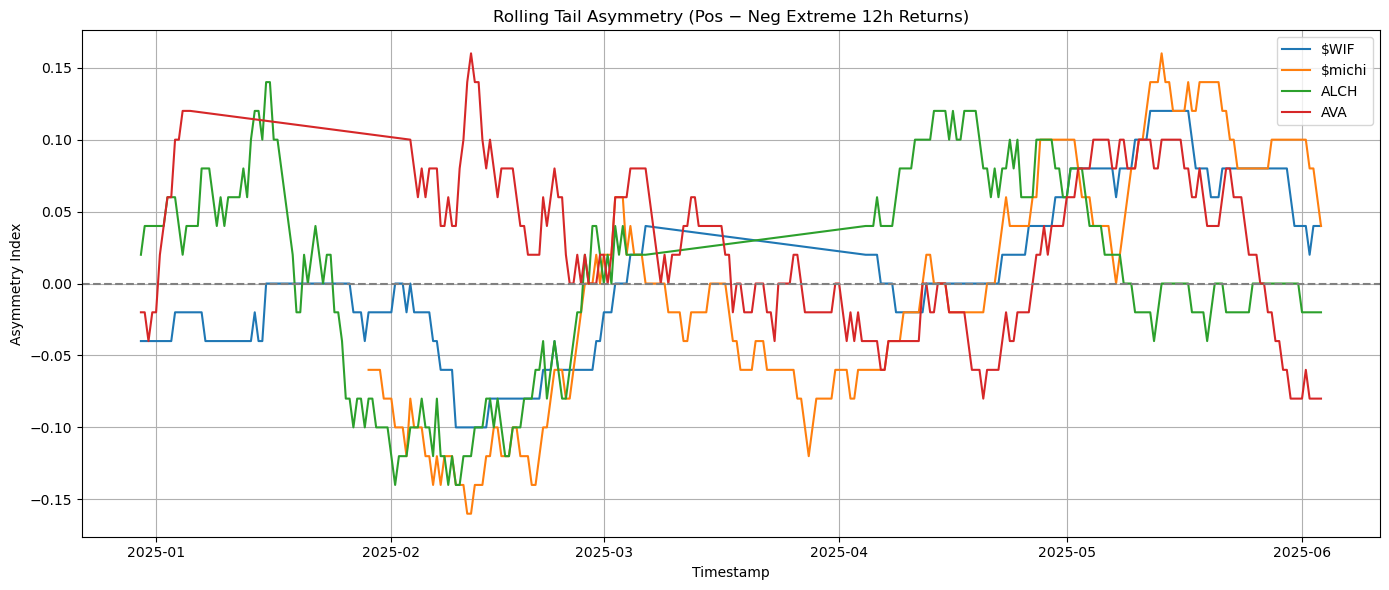
- Distribution of 12h Token Returns by SOL Macro Regime 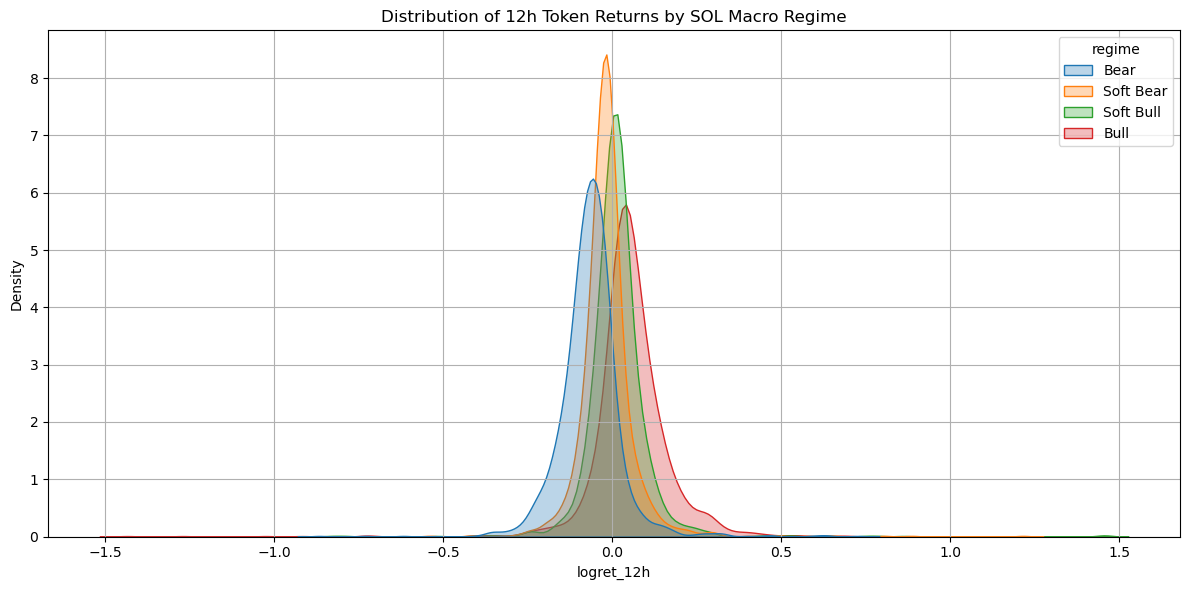
- ACF of Forecast Errors 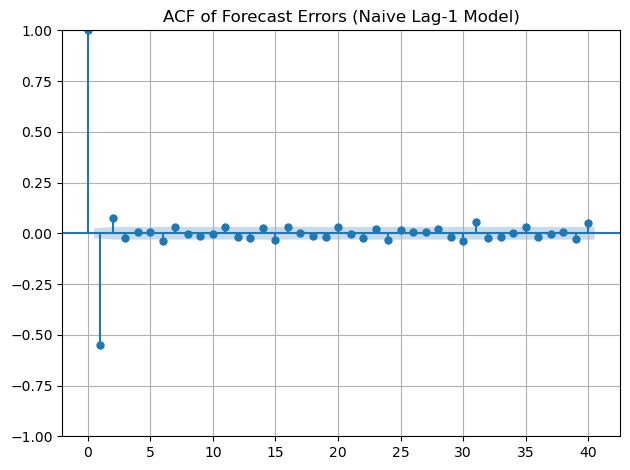

---

#### Next Steps  
- Tabulate token‐level skewness & kurtosis for 12 h and 72 h returns.  
- Formalize leverage‐effect feature (e.g. \`|logret_12h|\`, \`tail_flags\`) in the feature pipeline.  
- Explore QQ‐plots against Student-t to assess alternative parametric benchmarks.  


---

### Correlation & Redundancy Analysis

**Purpose**  
This notebook explores the interrelationships among 18 core features—spanning price, returns, volatility, momentum, on-chain counts, and macro/market context—using both Pearson (linear) and Spearman (rank) correlations. The goal is to identify and prune highly collinear inputs to stabilize tree-based quantile models, speed up training, uncover latent factor groupings, and guide feature combinations or dimensionality reduction for greater interpretability

---

**Methods**  
1. **Data preparation**: Reloaded the final imputed, returns-augmented dataset and renamed columns for clarity (e.g. `close_usd` → `token_close_usd`, `btc_eth_price_btc_close` → `btc_close_usd`, etc.)
2. **Feature selection**: Subsetted to 18 numeric features including token‐level price and volume, 12-h and 72-h log-returns, realized volatility, rolling skewness, tail asymmetry, extreme‐move frequency, on-chain counts, SOL/BTC/ETH closes, DeFi TVL and its 12-h change, and network transaction counts  
3. **Missing‐data handling**: Dropped any rows missing one or more of these core features to ensure a complete matrix for correlation analysis  
4. **Correlation computation**: Calculated pairwise Pearson and Spearman correlation matrices on the cleaned feature set   
5. **Visualization**: Rendered annotated heatmaps for both correlation types, highlighting strong positive and negative blocks across features   
6. **High-correlation detection**: Extracted all feature pairs with absolute Pearson correlation above 0.85 for targeted pruning or aggregation 

---

**Key Observations**  
- **Token price vs. volume**: `token_close_usd` and `token_volume_usd` exhibit near-perfect correlation (r ≈ 0.999) at the 12 h frequency.  
- **BTC & TVL**: `btc_close_usd` correlates strongly with `tvl_usd` (r ≈ 0.942), reflecting DeFi TVL’s sensitivity to Bitcoin moves.  
- **SOL & TVL**: `sol_close_usd` also aligns closely with `tvl_usd` (r ≈ 0.892), indicating overlapping market-context information 

---

**Implications for Feature Design**  
1. **Prune or combine**: Drop one variable from each highly correlated pair (e.g. keep volume or price—but not both), or engineer composite indicators (e.g. price×volume or normalized TVL).  
2. **Dimensionality reduction**: Consider PCA or feature clustering on market-context group (SOL, BTC, TVL) to capture common drivers with fewer components.  
3. **Non-linear checks**: After linear pruning, explore mutual information or nonlinear dependence metrics to detect subtler redundancies.  
4. **Model stability**: Reducing collinearity will make Quantile Regression Forests more robust and speed up training without sacrificing predictive power.

---

**Plots**  
- **Pearson Correlation Matrix** heatmap  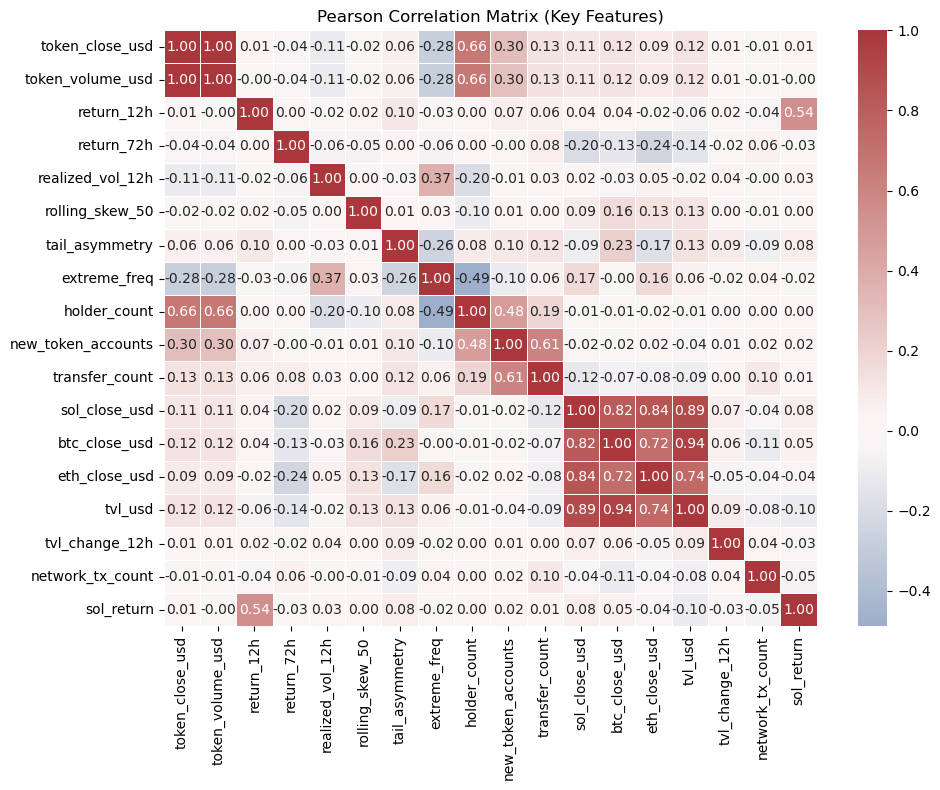 

---

**Next Steps**  
- Compute Variance Inflation Factors (VIFs) on the reduced feature set.  
- Evaluate alternative pruning thresholds (e.g. |r| > 0.75) for broader decorrelation.  
- Integrate composite features or principal components into Phase 2 modeling and reassess variable importance.  

---

### Interval Calibration (Naïve vs QRF)

**Purpose**  
To benchmark how simple Gaussian “± z·σ” intervals perform on 12 h returns against non-parametric QRF-based quantile intervals, quantifying both coverage and sharpness improvements .

---

**Methods**  
- **Naïve Gaussian intervals**  
  - Used 12 h log-returns (`return_12h`) and 36 h realized volatility (`realized_vol_12h`) from the cleaned panel.  
  - Defined nominal levels α ∈ {0.50, 0.55, …, 0.95}; for each α computed z = norm.ppf((1+α)/2).  
  - Formed intervals [–z·σ, +z·σ] around zero and measured empirical coverage (fraction of returns inside) and average interval width :contentReference[oaicite:0]{index=0}.  

- **QRF quantile intervals**  
  - Selected a simple feature set: `token_volume_usd`, `holder_count`, `sol_volume_usd`, and `realized_vol_12h`.  
  - Split the data into 70 % train / 30 % test.  
  - Fitted a `RandomForestQuantileRegressor(n_estimators=100)` on the training set to directly predict lower and upper quantiles for each α.  
  - On the test set, for each α, computed empirical coverage and mean interval width from the QRF quantile predictions :contentReference[oaicite:1]{index=1}.  

- **Visualization**  
  - Plotted empirical coverage vs. nominal α for both Naïve and QRF intervals against the 45° ideal line.  
  - Tabulated interval widths for Naïve vs. QRF at key coverage levels :contentReference[oaicite:2]{index=2}.  

---

**Key Observations**  
- **Under-coverage of Naïve intervals:** Gaussian bands under-cover substantially (e.g. nominal 80 % → ~70 % empirical).  
- **QRF calibration:** QRF intervals adhere much more closely to the ideal coverage line across all α, demonstrating superior calibration.  
- **Sharper intervals:** At α = 0.80, QRF intervals are narrower (avg. width 0.1682) than Naïve intervals (0.2038), achieving better sharpness at the same nominal level :contentReference[oaicite:3]{index=3}.  

---

**Implications**  
- **Non-parametric advantage:** QRF’s direct quantile estimates adapt to the fat-tailed, heteroskedastic return distribution, effectively closing the under-coverage gap of Gaussian assumptions.  
- **Baseline selection:** QRF should serve as the core benchmark before adding conformal or bootstrap calibration methods.  
- **Feature sufficiency:** Even this limited feature set allows QRF to outperform naive bands; richer features may further tighten intervals.

---

**Plots**  
- **Calibration Curve Comparison: Naïve vs QRF** (empirical vs nominal coverage)  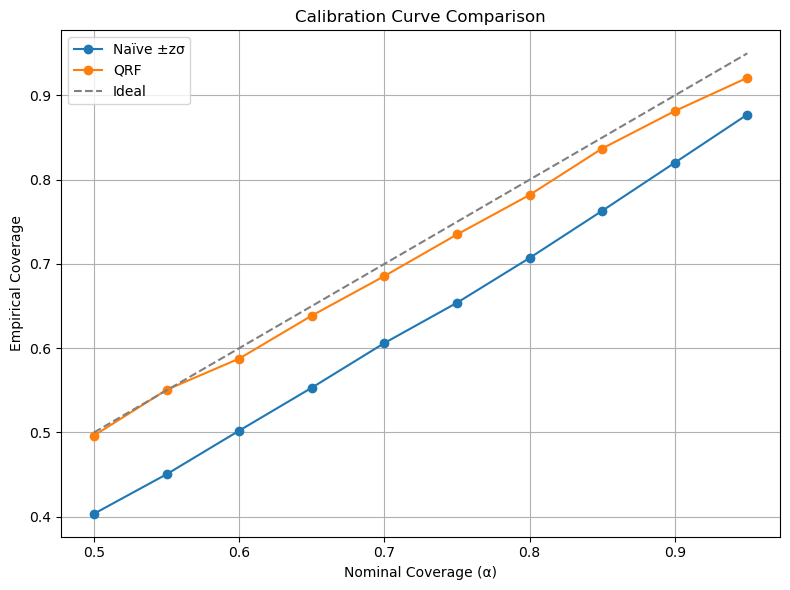
---

**Next Steps**  
1. Compare with LightGBM quantile regression intervals.  
2. Introduce rolling-window cross-validation to assess temporal stability.  
3. Apply split-conformal or block-bootstrap calibration around QRF for finite-sample coverage guarantees.  
 


---

### Rolling Conformal Calibration of QRF Intervals

**Purpose**  
Implement Conformalized Quantile Regression (CQR) around a Quantile Regression Forest (QRF) in a rolling-window framework to evaluate how conformal adjustments affect empirical coverage and interval sharpness of 72 h return forecasts, both overall and by market regime 

---

**Methods**  
- **Data & features:** Used the final cleaned panel with features including 12 h token volume, holder count, SOL volume, realized 12 h volatility, network transaction count, TVL and its change, SOL returns, extreme-move flags, rolling skewness, tail asymmetry, plus a regime label.  
- **Rolling scheme:** Employed windows of 120 bars (~60 days) for training, 30 bars for calibration, and 30 bars for testing, sliding forward one bin (12 h) at a time.  
- **Base model:** In each window, fitted `RandomForestQuantileRegressor(n_estimators=100, random_state=0)` to predict lower and upper quantiles at nominal levels α∈{0.50,0.55,…,0.95}.  
- **Conformal adjustment:** On the calibration fold, computed conformity scores  
  \[
    s_i = \max\bigl(\hat q_{\mathrm{lower}}(x_i)-y_i,\;y_i-\hat q_{\mathrm{upper}}(x_i),\;0\bigr),
  \]  
  set δ as the \(\lceil(1-\alpha)(n+1)\rceil/n\)-th quantile of these scores, then adjusted test quantiles by subtracting/adding δ.  
- **Metrics recorded:** For each α and window: naive vs conformal empirical coverage, interval widths, δ, and per-observation predictions (timestamp, y, naive_lower/upper, conf_lower/upper, residual, regime).  
- **Aggregations:** Computed overall calibration curves by α, regime-specific coverage and widths, time series of δ for α=0.80, and ACF of median residuals.

---

**Key Observations**  
- **Calibration collapse:** Conformal intervals shrink disastrously—empirical coverage falls from ≈45 % at α=0.50 down to ≈10 % at α=0.95, instead of lining up with the diagonal. 
- **Rolling δ behavior:** For α=0.80, δ swings between −0.28 and +0.05 with a median ≈−0.07, indicating negative corrections that further narrow intervals. 
- **Residual autocorrelation:** Forecast residuals (median quantile) exhibit strong ACF (~0.4) up to lag 20, violating the i.i.d. assumption of split-conformal.
- **Uniform miscoverage:** 80 % intervals cover only 20 %–36 % of returns across quintiles of realized volatility, transaction counts, and volume—no single regime explains the under-coverage. 
- **Sharpness vs coverage:** Conformal bands are narrower than naive QRF (e.g. width 0.1465 vs 0.2493 at α=0.80) but catastrophically under-cover, rendering sharpness meaningless without valid coverage.
- **Regime-specific sharpness:** At α=0.80, conformal widths range 0.2004–0.2624 vs naive 0.1111–0.1655 across bear/soft-bear/soft-bull/bull regimes, with neither method achieving acceptable coverage.

---

**Implications & Future Considerations**  
1. **Score redefinition:** Current δ can be negative. Redefine scores as \(\max(y_i-\hat q_{\mathrm{upper}},\,\hat q_{\mathrm{lower}}-y_i,\,0)\) or use MAPIE’s `MapieQuantileRegressor` for proven CQR.  
2. **Time-series dependence:** Strong autocorrelation demands time-series conformal (block bootstrap or `MapieTimeSeriesRegressor`) and calibration windows that respect serial structure.  
3. **Regime-conditioning:** Since miscoverage is uniform across regimes, experiment with separate δ for bull vs bear markets and rolling-regime calibration.  
4. **Feature enrichment:** Limited feature set yielded weak QRF quantiles—complete on-chain, liquidity, and other engineered features before re-running calibration.  
5. **Alternative base models:** QRF struggled here; implement LightGBM quantile regression + CQR to compare interval width vs coverage trade-offs.  
6. **Tail modeling & tests:** Residual heteroskedasticity and heavy tails suggest EVT models for extremes and formal Diebold–Mariano tests to compare methods.  
7. **Quantile granularity:** Extend from three to five quantiles (τ={0.05,0.25,0.50,0.75,0.95}) to check one-sided coverage diagnostics.

---

**Plots**  
- Rolling calibration curves: naive QRF vs CQR across α-levels  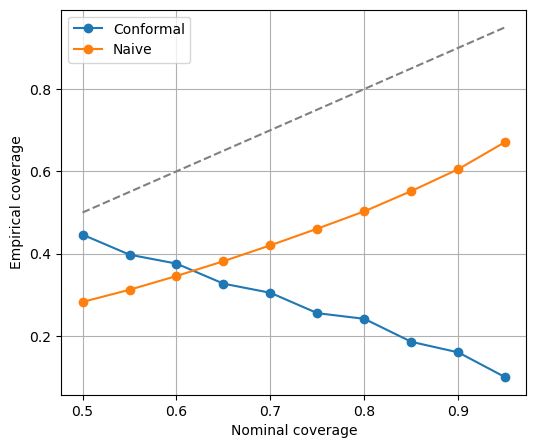
- Time series of δ for α=0.80  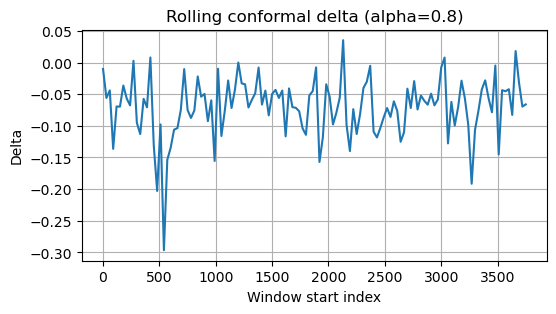
- ACF of median residuals (α=0.80)  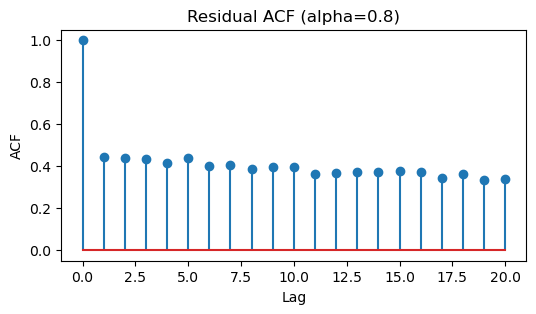

---

**Next Steps**  
- Correct conformity-score implementation and recalculate δ.  
- Adopt block-bootstrap or MAPIE time-series conformal methods.  
- Implement regime-aware CQR and evaluate improvements.  
- Enrich feature set and reassess base quantile predictions.  
- Benchmark QRF+CQR vs LightGBM+CQR with Diebold–Mariano tests for statistical significance.  


---

## 5. Consolidated Insights

Drawing together results from all EDA notebooks, we highlight key data characteristics, methodological take-aways, and implications for interval forecasting of 72 h returns in mid-cap Solana tokens.

---

**1. Data Quality & Coverage**  
- After cleaning and imputation, the core OHLCV panel is fully observed for all retained tokens, with zero residual gaps in `open_usd`–`volume_usd` fields  
- On-chain metrics only become available from 2025-02-07 onwards, leaving a ~2 month pre-start period with structural missingness; tokens like LAUNCHCOIN and TITCOIN remain unusable for on-chain features due to persistent 100 % and late-start gaps respectively .  
- Global market tables (BTC/ETH prices, TVL, transaction counts) incur < 1 % missingness once forward-filled to the master 12 h index.

**2. Return Distribution & Volatility Dynamics**  
- Both 12 h and 72 h log-returns exhibit pronounced right skew (≈ 0.67) and extreme kurtosis (≈ 27.7), confirming heavy tails that violate Gaussian assumptions 
- Volatility clustering is evident from a slowly decaying ACF in |log-returns| up to lag 20, indicating persistent heteroskedasticity  
- A strong negative lag-1 autocorrelation in naïve forecast errors reveals short-term mean-reversion (reversal) effects, underscoring the need for features capturing serial dependence.

**3. Feature Relationships & Redundancy**  
- Extreme collinearity was found between token price and volume (r ≈ 0.999), and between BTC close and TVL (r ≈ 0.94), as well as SOL close and TVL (r ≈ 0.89)  
- Pruning or combining these highly correlated inputs will reduce variance in quantile forests and improve interpretability; dimensionality reduction (e.g. PCA on market-context features) may capture common drivers with fewer variables.

**4. Baseline Interval Performance**  
- Naïve Gaussian ± z·σ bands systematically under-cover: the nominal 90 % interval covers only ~82 % of 12 h returns, and the 50 % band covers ~40 %  
- QRF-derived quantile intervals substantially close this gap: at α = 0.80 they achieve near-nominal coverage with narrower average width (0.1682 vs 0.2038 for Gaussian) using just four basic features

**5. Challenges in Conformal Calibration**  
- Rolling split-conformal adjustments around QRF produced negative δ values and overly narrow bands, leading to catastrophic under-coverage (e.g. 80 % intervals covering only 20 %–36 % of returns) across all regimes  
- Strong residual autocorrelation (ACF ≈ 0.4 at lag 1) violates i.i.d. assumptions, necessitating time-series–aware conformal methods (block-bootstrap or MAPIE’s time-series conformal) and regime-conditioned calibration.

---

**Overall Synthesis**  
- **Data readiness** is high for price features but limited for on-chain metrics before early February 2025.  
- **Return behavior** demands non-parametric quantile forecasting due to fat tails, skew, mean-reversion and volatility clustering.  
- **Feature engineering** must balance redundancy reduction with inclusion of tail-risk and serial-dependence signals.  
- **QRF** provides a strong baseline for interval estimation, outperforming Gaussian bands in both coverage and sharpness.  
- **Conformal methods**, as currently implemented, fail under time-series dependence but can be rescued with appropriate serial-block adjustments and regime conditioning.

These insights will guide the next phases of model design, calibration strategy refinement, and rigorous validation in the dissertation’s core chapters.  


---

## 6. Actionable Next Steps

Below we tie each next step directly to the EDA insights—highlighting what must be done differently or in light of specific findings.

- **Feature Engineering**  
  - **Tail‐risk & distributional features:** incorporate rolling 6-bar skewness/kurtosis because 12 h returns exhibit right‐skew (~0.67) and extreme kurtosis (~27.7)  
  - **Extreme‐move flags:** add binary indicators for |12 h return| > 10 % given sporadic fat‐tail events observed.  
  - **Mean‐reversion signals:** include lag-1 return and naïve forecast error after detecting strong negative autocorrelation at lag 1 in notebook 02   
  - **Market‐context composites:** replace raw SOL/BTC/TVL with a PCA or aggregate factor because BTC vs TVL (r≈0.94) and SOL vs TVL (r≈0.89) are highly collinear
  - **On‐chain feature windowing:** use holder_count, new_accounts and transfer_count only post-2025-02-07 and drop LAUNCHCOIN/TITCOIN as advised by notebook 01 .

- **Modeling Plan**  
  - **Gaussian baseline suffices only for sanity checks:** notebook 04 showed ± z·σ under-coverage (90 %→~82 %) ; use it strictly as a lower bar.  
  - **QRF as core benchmark:** direct quantile estimates in notebook 04 achieved near-nominal coverage and sharper intervals (0.1682 vs 0.2038 at α=0.80)  expand to full feature set.  
  - **LightGBM residual‐bootstrap:** include as a second non-parametric comparison given its complementary modeling biases.  
  - **Conformal calibration revision:** notebook 05’s split-conformal yielded negative δ and catastrophic under-coverage; switch to block-bootstrap or MAPIE TimeSeriesRegressor for valid finite-sample guarantees.

- **Validation Strategy**  
  - **Rolling-window CV:** replicate the 120-train/30-calibration/30-test sliding scheme from notebook 05 to capture temporal non-stationarity and volatility regimes.  
  - **Regime‐specific evaluation:** split results into bull vs bear (SOL signed return) as uniform miscoverage was observed across quintiles in notebook 05.  
  - **Cross-token aggregation:** pool metrics over all 23 tokens but also report token-level extremes to catch outliers.

- **Diagnostics to Revisit**  
  - **Residual dependence:** strong ACF (~0.4) in QRF+CQR residuals (notebook 05) demands time-series-aware conformal and possibly generalized autocovariance adjustments.  
  - **Heteroskedasticity checks:** re-run volatility‐clustering diagnostics on residuals (ACF of |residuals|) to ensure new intervals adapt to changing variance.  
  - **Collinearity monitoring:** compute VIFs on the engineered feature set to confirm that pruning (e.g. price vs volume) has sufficiently reduced multicollinearity.  
  - **Coverage calibration plots:** overlay naïve, QRF, LGBM, and revised CQR curves to visually assess improvements across quantiles.  
  - **Statistical tests:** apply Diebold–Mariano tests between top methods to establish significant gains in pinball loss and interval calibration.


---